# Pass Networks in Python

Made from [this video](https://www.youtube.com/watch?v=fPcY9dbOMGM) by McKay Johns.

## Prepare

### Importing

In [35]:
from statsbombpy import sb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
from mplsoccer.pitch import Pitch
from mplsoccer import FontManager

## Getting data from Statsbomb API

In [36]:
MATCH_ID = 22912
events = sb.events(match_id = MATCH_ID)
# passes = sb.events(match_id = MATCH_ID, split=True, flatten_attrs=False)['passes']

credentials were not supplied. open data access only


### Clear data
- Select only one team (Liverpool).
- Split location and pass_end_location to separate columns for x and y coordinates
- Change NaN at outcome to Successful string

In [37]:
def pass_data_from_events(events, team, lineup_team, onlySuccessful = False):    
    # Create mask to filter events dataframe
    mask_team = (events['type'] == 'Pass') & (events['team'] == team)

    # Filter
    df_pass_team = events.loc[mask_team, ['team', 'player', 'minute', 'second', 'type', 'pass_outcome', 'location', 'pass_end_location', 'pass_recipient']]
    
    # Split location column to x, y columns, and drop location column
    df_pass_team[['x','y']] = df_pass_team['location'].to_list()
    df_pass_team.drop('location', axis=1, inplace=True)

    # Split pass_end_location column to endX and endY columns, and drop pass_end_location column
    df_pass_team[['endX','endY']] = df_pass_team['pass_end_location'].to_list()
    df_pass_team.drop('pass_end_location', axis=1, inplace=True)

    # Fill NaN at pass_outcome column with Successful string
    df_pass_team['pass_outcome'] = df_pass_team['pass_outcome'].fillna('Successful')

    # Rename pass_outcome column to just outcome
    df_pass_team.rename(columns={'pass_outcome': 'outcome'}, inplace=True)
    
    # Add passer number to dataframe
    df_pass_team = pd.merge(df_pass_team, lineup_team, left_on='player', right_on='player_name', how='left')
    df_pass_team.rename(columns={'jersey_number': 'passer'}, inplace=True)
    df_pass_team.drop('player_name', axis=1, inplace=True)
    
    # Add recipient number to dataframe
    df_pass_team = pd.merge(df_pass_team, lineup_team, left_on='pass_recipient', right_on='player_name', how='left')
    df_pass_team.rename(columns={'jersey_number': 'recipient'}, inplace=True)
    df_pass_team.drop('player_name', axis=1, inplace=True)
    
    # Cast to integer CAN'T CAST IT IN FUNCTION
#     recipient = pd.to_numeric(df_pass_team['recipient'], downcast = 'integer')
#     df_pass_team['recipient'] = recipient
    
    # Filter only successful passes
    if onlySuccessful:
        mask_successful = df_pass_team['outcome'] == 'Successful'
        df_pass_team = df_pass_team[mask_successful]
    return df_pass_team

In [38]:
TEAM = 'Liverpool'
FORMATION = 433
OPPONENT = 'versus Tottenham Hotspur, 2018/19 Champions League'
# Liverpool lineup
lineup_team = sb.lineups(match_id = MATCH_ID)[TEAM]
lineup_team.drop(['player_id', 'player_nickname', 'country'], axis=1, inplace=True)

passes = pass_data_from_events(events, TEAM, lineup_team, onlySuccessful = True)
passes['recipient'] = pd.to_numeric(passes['recipient'], downcast = 'integer')
passes

credentials were not supplied. open data access only


,team,player,minute,second,type,outcome,pass_recipient,x,y,endX,endY,passer,recipient
0,Liverpool,Jordan Brian Henderson,0,0,Pass,Successful,Joël Andre Job Matip,61.0,41.0,34.9,44.7,14,32
4,Liverpool,Virgil van Dijk,0,14,Pass,Successful,Georginio Wijnaldum,60.4,20.5,66.3,20.1,4,5
5,Liverpool,Georginio Wijnaldum,0,16,Pass,Successful,Jordan Brian Henderson,65.6,19.3,65.8,24.7,5,14
6,Liverpool,Jordan Brian Henderson,0,17,Pass,Successful,Sadio Mané,65.2,25.2,100.1,25.4,14,10
11,Liverpool,Andrew Robertson,3,19,Pass,Successful,Sadio Mané,44.6,1.0,54.5,9.4,26,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
312,Liverpool,Trent Alexander-Arnold,89,57,Pass,Successful,Divock Okoth Origi,54.4,55.0,58.6,34.7,66,27
320,Liverpool,Fábio Henrique Tavares,94,16,Pass,Successful,Divock Okoth Origi,40.9,53.5,55.2,57.4,3,27
321,Liverpool,Divock Okoth Origi,94,18,Pass,Successful,Mohamed Salah,63.8,54.7,96.4,72.6,27,11
322,Liverpool,Mohamed Salah,94,26,Pass,Successful,Divock Okoth Origi,97.6,61.3,93.5,56.7,11,27


### Filter passes before first substitution

In [39]:
mask_subs = events['type'] == 'Substitution'

subs = events.loc[mask_subs, ['team', 'player', 'substitution_outcome', 'substitution_replacement', 'minute', 'second']]
subs_minutes = subs['minute']

first_sub = subs_minutes.min()

passes = passes[passes['minute'] < first_sub]
passes

,team,player,minute,second,type,outcome,pass_recipient,x,y,endX,endY,passer,recipient
0,Liverpool,Jordan Brian Henderson,0,0,Pass,Successful,Joël Andre Job Matip,61.0,41.0,34.9,44.7,14,32
4,Liverpool,Virgil van Dijk,0,14,Pass,Successful,Georginio Wijnaldum,60.4,20.5,66.3,20.1,4,5
5,Liverpool,Georginio Wijnaldum,0,16,Pass,Successful,Jordan Brian Henderson,65.6,19.3,65.8,24.7,5,14
6,Liverpool,Jordan Brian Henderson,0,17,Pass,Successful,Sadio Mané,65.2,25.2,100.1,25.4,14,10
11,Liverpool,Andrew Robertson,3,19,Pass,Successful,Sadio Mané,44.6,1.0,54.5,9.4,26,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,Liverpool,Georginio Wijnaldum,53,1,Pass,Successful,Mohamed Salah,54.4,34.8,102.0,55.5,5,11
212,Liverpool,Georginio Wijnaldum,53,13,Pass,Successful,Jordan Brian Henderson,91.1,48.9,91.8,59.1,5,14
213,Liverpool,Jordan Brian Henderson,53,14,Pass,Successful,Fábio Henrique Tavares,91.8,59.1,83.9,48.3,14,3
214,Liverpool,Fábio Henrique Tavares,53,15,Pass,Successful,Andrew Robertson,83.9,48.3,83.2,20.8,3,26


## Plotting

### Working with data

In [40]:
average_locations = passes.groupby(['passer']).agg({'x':[np.mean], 'y': [np.mean, 'count']})
average_locations.columns = ['x', 'y', 'count']
average_locations

,x,y,count
passer,,,
3,56.933333,44.044444,9
4,31.855556,28.655556,18
5,74.150000,31.325000,12
9,94.775000,37.387500,8
10,71.733333,20.500000,12
11,94.500000,52.720000,5
13,12.313333,41.546667,15
14,75.414286,49.950000,14
26,52.478261,9.213043,23


In [41]:
# Count passes between each pair of players
pass_between = passes.groupby(['passer','recipient']).size().reset_index(name='pass_count')

# Merge with average locations
pass_between = pass_between.merge(average_locations, left_on = 'passer', right_index = True)
pass_between = pass_between.merge(average_locations, left_on = 'recipient', right_index = True, suffixes = ('', '_end'))
pass_between = pass_between[pass_between['pass_count'] > 1]
pass_between

,passer,recipient,pass_count,x,y,count,x_end,y_end,count_end
22,9,10,2,94.775000,37.387500,8,71.733333,20.500000,12
43,14,10,3,75.414286,49.950000,14,71.733333,20.500000,12
52,26,10,6,52.478261,9.213043,23,71.733333,20.500000,12
66,66,10,2,69.323077,68.115385,13,71.733333,20.500000,12
9,4,13,4,31.855556,28.655556,18,12.313333,41.546667,15
53,26,13,2,52.478261,9.213043,23,12.313333,41.546667,15
61,32,13,2,34.171429,50.885714,14,12.313333,41.546667,15
2,3,14,3,56.933333,44.044444,9,75.414286,49.950000,14
10,4,14,2,31.855556,28.655556,18,75.414286,49.950000,14
18,5,14,2,74.150000,31.325000,12,75.414286,49.950000,14


### Calculate line width and marker sizes

In [42]:
MAX_LINE_WIDTH = 18
MAX_MARKER_SIZE = 3000
pass_between['width'] = (pass_between.pass_count / pass_between.pass_count.max() * MAX_LINE_WIDTH)
average_locations['marker_size'] = (average_locations['count'] / average_locations['count'].max() * MAX_MARKER_SIZE)

### Set color to make line more transparent when fewer passes are made

In [43]:
MIN_TRANSPARENCY = 0.3
color = np.array(to_rgba('white'))
color = np.tile(color, (len(pass_between), 1))
c_transparency = pass_between.pass_count / pass_between.pass_count.max()
c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
color[:, 3] = c_transparency

### Drawing

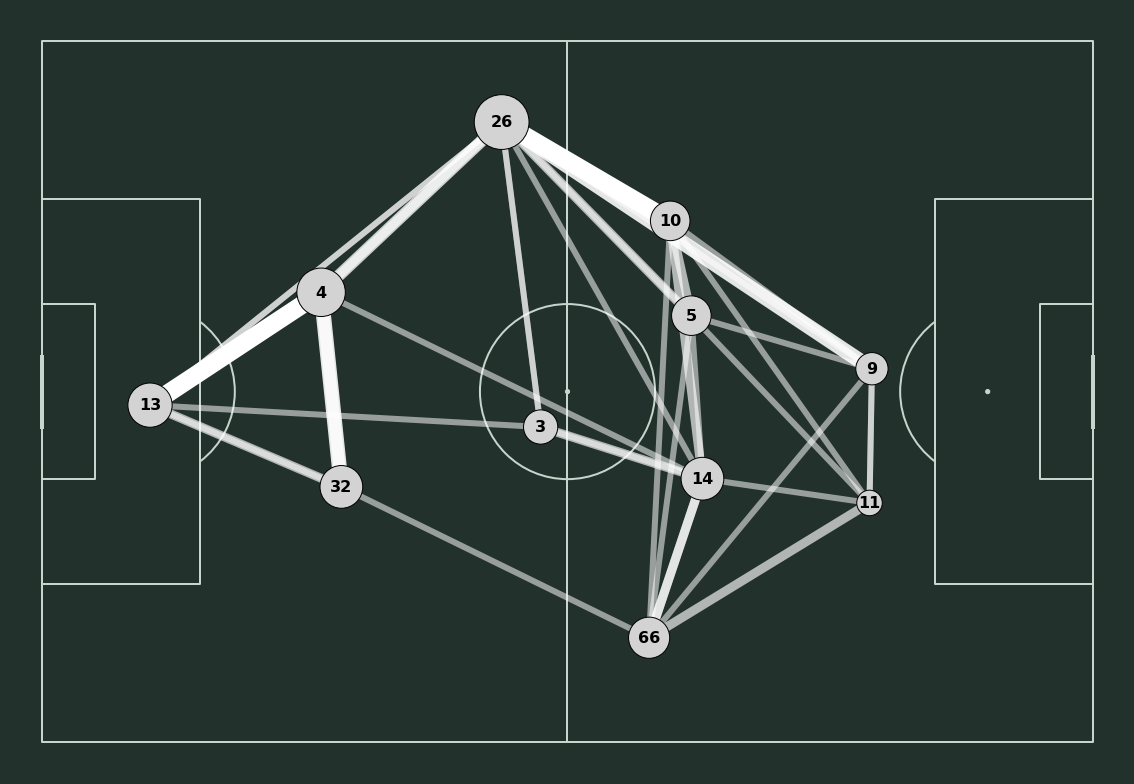

In [44]:
# plot the pitch
pitch = Pitch(pitch_type='statsbomb', pitch_color='#22312b', line_color='#c7d5cc')
fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=False, tight_layout=True)
fig.set_facecolor("#22312b")

# plot the arrows
arrows = pitch.lines(
    pass_between.x, pass_between.y, pass_between.x_end, pass_between.y_end, 
    lw = pass_between.width, color = color, zorder = 1, ax = ax
)

# plot the nodes
nodes = pitch.scatter(
    average_locations.x, average_locations.y,
    s = average_locations.marker_size, 
    color = '#d3d3d3', edgecolors = 'black', 
    linewidth = 1, alpha = 1, zorder = 1, ax = ax
)

# annotate the nodes with player number
for index, row in average_locations.iterrows():
    pitch.annotate(
        row.name, 
        xy=(row.x, row.y), 
        c='black', va='center', ha='center', 
        size=16, weight='bold', ax=ax
    )

Text(0.5, 0.25, 'versus Tottenham Hotspur, 2018/19 Champions League')

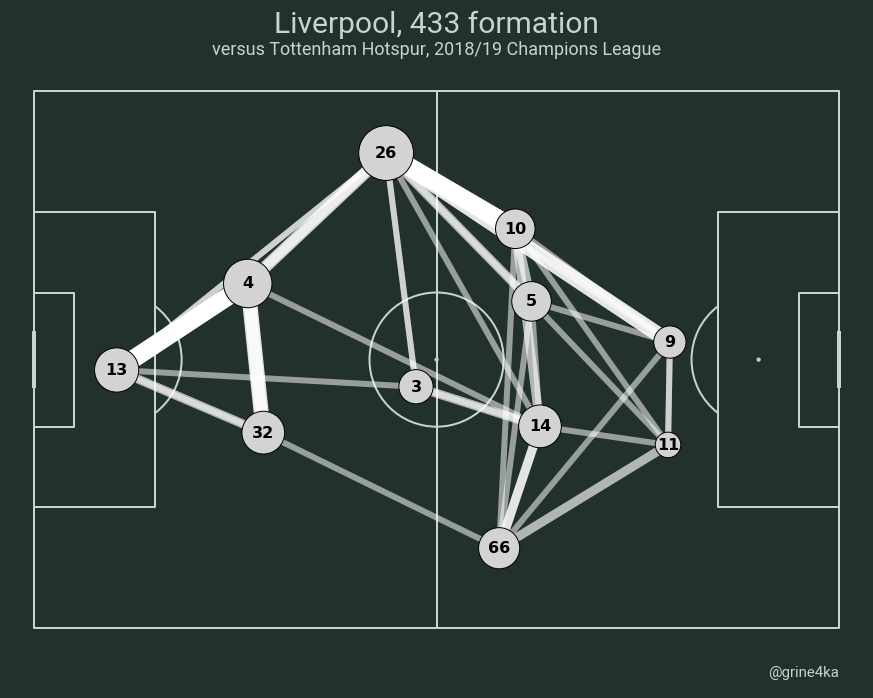

In [45]:
# plot the grid with title and endnote
fig, axs = pitch.grid(
    figheight=10, 
    title_height=0.08, 
    endnote_space=0,
    # Turn off the endnote/title axis. I usually do this after
    # I am happy with the chart layout and text placement
    axis=False,
    title_space=0, 
    grid_height=0.82, 
    endnote_height=0.05
)
fig.set_facecolor("#22312b")

# plot the arrows
arrows = pitch.lines(
    pass_between.x, pass_between.y, pass_between.x_end, pass_between.y_end, 
    lw = pass_between.width, color = color, zorder = 1, ax = axs['pitch']
)

# plot the nodes
nodes = pitch.scatter(
    average_locations.x, average_locations.y,
    s = average_locations.marker_size, 
    color = '#d3d3d3', edgecolors = 'black', 
    linewidth = 1, alpha = 1, zorder = 1, ax = axs['pitch']
)

# annotate the nodes with player number
for index, row in average_locations.iterrows():
    pitch.annotate(
        row.name, 
        xy=(row.x, row.y), 
        c='black', va='center', ha='center', 
        size=16, weight='bold', ax=axs['pitch']
    )
    
# Load a custom font.
URL = 'https://github.com/googlefonts/roboto/blob/main/src/hinted/Roboto-Regular.ttf?raw=true'
robotto_regular = FontManager(URL)

# endnote / title
axs['endnote'].text(
    1, 0.5, '@grine4ka', 
    color='#c7d5cc', va='center', ha='right', 
    fontsize=15, fontproperties=robotto_regular.prop
)

TITLE_TEXT = f'{TEAM}, {FORMATION} formation'
axs['title'].text(
    0.5, 0.7, TITLE_TEXT, 
    color='#c7d5cc', va='center', ha='center', 
    fontproperties=robotto_regular.prop, fontsize=30
)
axs['title'].text(
    0.5, 0.25, OPPONENT, 
    color='#c7d5cc', va='center', ha='center', 
    fontproperties=robotto_regular.prop, fontsize=18
)

In [46]:
fig.savefig('liverpool-vs-tottenham-ecl-2018-19.png')